# Project work part 3

Copy necessary parts from part 1 and 2.

We use our own diversity score function.

To run the code install all imported packages and run all cells in order.

In [105]:
import numpy as np
import polars as pl

# read data
links_df = pl.read_csv("../data/links.csv", schema={"movieId": pl.Int32, "imdb": pl.Int32, "tmdbId": pl.Int32})
movies_df = (
    pl.read_csv("../data/movies.csv", schema={"movieId": pl.Int32, "title": pl.String, "genres": pl.String})
    .with_row_index()
    .with_columns(
        pl.col("index")
        .cast(pl.Int32)
    )
)
ratings_df = pl.read_csv("../data/ratings.csv", schema={"userId": pl.Int32, "movieId": pl.Int32, "rating": pl.Float32, "timestamp": pl.Int32})
tags_df = pl.read_csv("../data/tags.csv", schema={"userId": pl.Int32, "movieId": pl.Int32, "tag": pl.String, "timestamp": pl.Int32})

To produce diverse recommendations we need a diversity score and some way to count it. We have movie genres and tags as additional information of movies. Let's see if there is any help of them. 

In [106]:
# Find tags for movies that have at least 2 appearances
movie_tags_df = (
    tags_df
    .with_columns(pl.col("tag").str.to_lowercase())
    .group_by("tag")
    .agg(
        pl.count("movieId").alias("count"),
        pl.col("movieId")
    )
    .filter(pl.col("count") > 1)
    .sort("count", descending=True)
    .drop("count")
    .explode("movieId")
    .select(["movieId", "tag"])
    .unique()
    .sort(["movieId", "tag"])
)
print(movie_tags_df)

# Genres for movies
genres_of_movies_df = (
    movies_df
    .with_columns(pl.col("genres").str.split("|"))
    .explode("genres")
    .with_columns(pl.col("genres").str.to_lowercase())
    # Filter markings of no genres
    .filter(pl.col("genres") != "(no genres listed)")
    .drop(["index", "title"])
)
print(genres_of_movies_df)

total_genres = genres_of_movies_df.select("genres").n_unique()
print()

# Count percentage of movies with genres and tags
n_movies_with_tags = movie_tags_df.select("movieId").n_unique()
n_movies_total = movies_df.select("movieId").n_unique()

print(f"Percentage of movies with tags: {n_movies_with_tags / n_movies_total * 100:.2f} %")

n_movies_with_genres = genres_of_movies_df.select("movieId").n_unique()
print(f"Percentage of movies with genres: {n_movies_with_genres / n_movies_total * 100:.2f} %")

shape: (2_649, 2)
┌─────────┬────────────────┐
│ movieId ┆ tag            │
│ ---     ┆ ---            │
│ i32     ┆ str            │
╞═════════╪════════════════╡
│ 1       ┆ fun            │
│ 1       ┆ pixar          │
│ 2       ┆ fantasy        │
│ 2       ┆ robin williams │
│ 5       ┆ pregnancy      │
│ …       ┆ …              │
│ 187593  ┆ ryan reynolds  │
│ 187593  ┆ sarcasm        │
│ 187595  ┆ star wars      │
│ 193565  ┆ anime          │
│ 193565  ┆ comedy         │
└─────────┴────────────────┘
shape: (22_050, 2)
┌─────────┬───────────┐
│ movieId ┆ genres    │
│ ---     ┆ ---       │
│ i32     ┆ str       │
╞═════════╪═══════════╡
│ 1       ┆ adventure │
│ 1       ┆ animation │
│ 1       ┆ children  │
│ 1       ┆ comedy    │
│ 1       ┆ fantasy   │
│ …       ┆ …         │
│ 193583  ┆ fantasy   │
│ 193585  ┆ drama     │
│ 193587  ┆ action    │
│ 193587  ┆ animation │
│ 193609  ┆ comedy    │
└─────────┴───────────┘

Percentage of movies with tags: 13.79 %
Percentage of movies 

We notice that only 13.79 % of movies have tags (which are used at least once) in them. However, 99.67 % of movies have genres. This means that we can use genres to calculate diversity score for almost all movies. Tags provide very little information for the diversity score so we do not use them.

Now we propose a diversity score function that takes into account genres. We do this by simply counting the amount of unique genres in the movies that we want to calculate the diversity score for. We then divide this count by the total amount of genres in the dataset. This way we get a percentage of genres that the movies cover.

In [107]:
movie_ids = [1,2]

def diversity_score(movie_ids):
    n_genres = (
        genres_of_movies_df
        .filter(pl.col("movieId").is_in(movie_ids))
        .select("genres")
        .n_unique()
    )    
    
    return n_genres / total_genres

print(f"Diversity score for movies {movie_ids}: {diversity_score(movie_ids)}")

Diversity score for movies [1, 2]: 0.2631578947368421


Here we have copied some stuff from previous parts

In [108]:
from sklearn.metrics.pairwise import nan_euclidean_distances

def get_top_n_most_similar_users_euclidean(user_id, n):
    rating_vectors_df = (
        ratings_df
        .drop("timestamp")
        .pivot("movieId", index="userId")
    )
    
    user_ratings = rating_vectors_df.filter(pl.col("userId") == user_id).drop("userId").to_numpy()
    
    rating_vectors = (
        rating_vectors_df
        .drop("userId")
        .to_numpy()
    )
    
    # Calculate distance
    distances = nan_euclidean_distances(rating_vectors, user_ratings).reshape(-1)
    
    # Find nan values and count the amount of common movies between user and all users
    nans_in_user_ratings = np.isnan(user_ratings[0])
    nans_in_rating_vectors = np.isnan(rating_vectors)
    common_rated_movies = 1 - np.logical_or(nans_in_user_ratings, nans_in_rating_vectors)
    common_rated_movies_count = np.sum(common_rated_movies, axis=1).astype(np.float32) 
    
    # Ignore users withe less than 5 common movies
    common_rated_movies_count[common_rated_movies_count < 5] = np.nan 
    
    # Count average distances
    average_distances = distances / common_rated_movies_count
    
    # Max scaling
    max_average_distance = np.nanmax(average_distances)
    
    # Distance to similarity. Nan values are set to zero
    similarities = np.nan_to_num(1 - (average_distances / max_average_distance))
    
    distance_df = (
        pl.DataFrame(
            {
                "userId": rating_vectors_df.select("userId"),
                "similarity": similarities
            }
        )
        .sort("similarity", descending=True)
        .limit(n)
    )
    
    return (
        distance_df
        .select("userId")
        .to_numpy()
        .reshape(-1)
    ), (
        distance_df
        .select("similarity")
        .to_numpy()
        .reshape(-1)
    )

In [109]:
# Define some helper functions to extract data from the dataframes

# ratings
def get_ratings_for_users(user_ids):
    return (
        ratings_df
        .drop("timestamp")
        .sort("movieId")
        .pivot("userId", index="movieId")
        .drop("movieId")
        .select([str(user_id) for user_id in user_ids])
        .transpose(include_header=True, header_name="userId", column_names=user_ids)
        .drop("userId")
        .to_numpy()
    )

# ratings mean
def get_mean_ratings_for_users(user_ids):
    return (
        ratings_df
        .drop("timestamp")
        .sort("movieId")
        .pivot("userId", index="movieId")
        .drop("movieId")
        .select([str(user_id) for user_id in user_ids.tolist()])
        .select(pl.all().mean())
        .transpose(include_header=True, header_name="userId", column_names=["ratings_mean"])
        .cast({"userId": pl.Int16})
        .filter(pl.col("userId").is_in(user_ids))
        .select("ratings_mean")
        .to_numpy()
        .reshape(-1)
    )

# movie indices for movie ids
def get_movie_indices_for_movie_ids(movie_ids):
    return (
        ratings_df
        .select("movieId")
        .unique()
        .sort("movieId")
        .with_row_index()
        .filter(pl.col("movieId").is_in(movie_ids))
        .select("index")
        .to_numpy()
        .reshape(-1)
    )

# single user rating mean
def get_user_rating_mean(user_id):
    return get_mean_ratings_for_users(np.array([user_id]))[0]

# candidate movie ids
def get_candidate_movie_ids(user_id, similar_user_ids):
    rated_by_user = (
        ratings_df
        .filter(pl.col("userId") == user_id)
        .select("movieId")
        .to_numpy()
        .reshape(-1)
    )

    return (
        ratings_df
        .filter(
            pl.col("userId").is_in(similar_user_ids), # only include ratings from similar users
            pl.col("movieId").is_in(rated_by_user).not_() # only include movies that the user has not rated
        )
        .group_by("movieId")
        .agg()
        .select("movieId")
        .to_numpy()
        .reshape(-1)
    )

In [110]:
def predict_movies(user_ratings_mean, similar_users_ratings, similar_users_ratings_mean, similarity_scores, candidate_movie_indices, num_of_movies):
    """
    The prediction function from course slides.

    :param user_ratings_mean: mean of user ratings
    :param similar_users_ratings: sparse numpy 2D matrix of similar users ratings. Each row is a user and each column is a movie
    :param similar_users_ratings_mean: numpy array of mean ratings of the similar users
    :param similarity_scores: numpy array of similarity scores between the user and the similar users
    :param candidate_movie_indices: numpy array of movie indices that the similar users have rated
    :param num_of_movies: number of movies to recommend
    :return: top ranked candidate movie indices, and their predicted ratings
    """
    
    # Compute ratings only for the candidate movies to save computation
    candidate_similar_users_ratings = np.take(similar_users_ratings, candidate_movie_indices, axis=1)

    # Subtract mean rating from each rating, (r_b,p - r_b)
    delta_ratings = candidate_similar_users_ratings - similar_users_ratings_mean.reshape(similar_users_ratings_mean.shape[0], 1)

    # Sum sim(a,b) * (r_b,p - r_b)
    numerator = np.sum(similarity_scores.reshape(-1, 1) * delta_ratings, axis=0)

    # Sum |sim(a,b)|, taking absolute value to avoid negative bias even though it should not be possible
    denominator = np.sum(np.abs(similarity_scores))

    # Sum sim(a,b) * (r_b,p - r_b) / Sum |sim(a,b)|
    bias = numerator / denominator

    # pred(a,p) = r_a + bias
    predicted_ratings = user_ratings_mean + bias

    # Rank the movies by predicted rating
    indices = np.flip(np.argsort(predicted_ratings))
    predicted_movie_indices = candidate_movie_indices[indices][:num_of_movies]
    sorted_ratings = predicted_ratings[indices][:num_of_movies]

    return predicted_movie_indices, sorted_ratings

In [111]:
def predict_movies_for_user(user_id, num_of_movies):
    similar_user_ids, similarity_scores = get_top_n_most_similar_users_euclidean(user_id, 50)
    
    user_ratings_mean = get_user_rating_mean(user_id)
    # print(user_ratings_mean)
    similar_users_ratings = np.nan_to_num(get_ratings_for_users(similar_user_ids))
    # print(similar_users_ratings)
    similar_users_ratings_mean = get_mean_ratings_for_users(similar_user_ids)
    # print(similar_users_ratings_mean)
    candidate_movie_ids = get_candidate_movie_ids(user_id, similar_user_ids)

    candidate_movie_indices = get_movie_indices_for_movie_ids(candidate_movie_ids)

    return predict_movies(user_ratings_mean, similar_users_ratings, similar_users_ratings_mean, similarity_scores, candidate_movie_indices, num_of_movies)

Group recommendation function to recommend next movie to watch for the group is defined as follows: 
We combine the ideas of both least misery and average aggregation methods. What this means is that we try to find the least satisfied subgroup of the group and recommend the movie that has the highest average rating in that subgroup. This way we try to maximize the satisfaction of the least satisfied users in the group. We chose average aggregation since it provided the best satisfaction scores for individual users. By doing this we try to get rid of the problem where average aggregation method would always ignore one member of the group while also providing very likable movies to a subgroup of users. 

As time goes on the average scores should in theory converge to a point where all users are equally satisfied. This of course relies on the idea that the users will have some movies that they truly like.

In [112]:
# Keep track of previously watched movies and ratings
watched_movies_ratings = pl.DataFrame(
    data={
        "movie_index": [],
        "rating": [],
        "userId": []
    },
    schema={
        "movie_index": pl.Int32,
        "rating": pl.Float32,
        "userId": pl.Int32
    }
)

In [ ]:
def recommend_next_movie_to_watch(user_ids, least_satisfied_user_ids, n_movies):
    """
    Average aggregated movie recommendations for a group of users.
    
    :param user_ids: group of users 
    :param least_satisfied_user_ids: least satisfied users subgroup 
    :return: movie ids 
    """
    
    # Find movie recommendations for all users
    
    predicted_movie_indices = np.ndarray(shape=(len(user_ids), n_movies), dtype=np.int32)
    predicted_ratings = np.ndarray(shape=(len(user_ids), n_movies), dtype=np.float32)
    
    for index, user_id in enumerate(user_ids):
        user_movie_indices, ratings = predict_movies_for_user(user_id, n_movies)
        predicted_movie_indices[index] = user_movie_indices
        predicted_ratings[index] = ratings
    
    # Combine the predictions into a dataframe
    predictions_df = (
        pl.DataFrame({
             "movie_index": predicted_movie_indices.reshape(-1),
             "predicted_rating": predicted_ratings.reshape(-1),
             "userId": np.array([[user_id] * n_movies for user_id in user_ids]).reshape(-1)
        })
        .unique()
        )
    
    # Find movies which have rating for all users in the group
    movie_ratings_count = (
        predictions_df
        .group_by("movie_index")
        .agg(
            pl.count("predicted_rating")
            .alias("ratings_count")
        )
        .filter(pl.col("ratings_count") >= 5)
        .sort("ratings_count", descending=True)
    )
    
    # filter predictions_df to only include movies that have been rated by all users in the group
    predictions_df = (
        predictions_df
        .filter(
            pl.col("movie_index")
            .is_in(movie_ratings_count.select("movie_index")
            )
        )
        .sort("movie_index")
        .pivot("movie_index", index="userId")
    )
    
    # Calculate the average rating for each movie for least satisfied users
    average_ratings_df = (
        predictions_df
        .filter(pl.col("userId").is_in(least_satisfied_user_ids))
        .drop("userId")
        .mean()
    )
    
    # find the top movie to predict based on the average rating of the subgroup
    recommended_movie_index = (
        average_ratings_df
        .transpose(include_header=True, header_name="index", column_names=["avg_rating"])
        .with_columns(
            pl.col("index")
            .cast(pl.Int32)
        )
        .sort("avg_rating", descending=True)
        # Make sure the movie has not been watched by the group already
        .filter(pl.col("index").is_in((watched_movies_ratings.select("movie_index").unique().to_series().to_list())).not_())
        .limit(1)
        .join(movies_df, on="index", how="left")
        .select("index")
        .to_numpy()
        .reshape(-1)
        [0]
    )
    
    # Find predicted ratings for the recommended movie for all users
    predicted_user_ratings = (
        predictions_df
        .sort("userId")
        .select([str(recommended_movie_index)])
        .to_numpy()
        .reshape(-1)
    )
    
    return recommended_movie_index, predicted_user_ratings

In [114]:
def set_movie_watched(movie_index, user_ratings, user_ids):
    """
    Helper function to set a movie as watched by the group of users.
    """
    
    new_rows = pl.DataFrame(
        data={
            "movie_index": [movie_index] * len(user_ids),
            "rating": user_ratings,
            "userId": user_ids
        },
        schema={
            "movie_index": pl.Int32,
            "rating": pl.Float32,
            "userId": pl.Int32
        }
    )
    
    watched_movies_ratings.extend(new_rows)

In [115]:
def find_least_satisfied_users():
    """
    Helper function to find the least satisfied subgroup of users.
    
    Subgroup is defined by finding the biggest delta in value in sorted average ratings between users. The function finds a subgroup of users that are "left behind" by the group.
    """
    
    # Find average scores of movies which have been watched by the group
    average_ratings_df = (
        watched_movies_ratings
        .group_by("userId")
        .agg(
            pl.col("rating").mean().alias("avg_rating")
        )
        .sort("avg_rating", descending=True)
    )
    print(average_ratings_df)
    
    # Order users by average rating
    sorted_users = average_ratings_df.select("userId").to_numpy().reshape(-1)
    
    # Boundary user is the user who is boundary to the least satisfied subgroup of users. 
    boundary_user_id = (
        average_ratings_df
        # Calculate delta ratings
        .with_columns(
            next_rating=pl.col("avg_rating").shift(-1)
        )
        .drop_nulls()
        .with_columns(
            delta_rating=pl.col("avg_rating") - pl.col("next_rating")
        )
        # Sort by delta rating to find the boundary user
        .select("userId", "delta_rating")
        .sort("delta_rating", descending=True)
        .limit(1)
        .select("userId")
        .to_numpy()
        .reshape(-1)
        [0]
    )
    
    # Boundary user is left out of the subgroup
    least_satisfied_users = sorted_users[np.where(sorted_users == boundary_user_id)[0][0]+1:]
    
    return least_satisfied_users

Let's try our proposed method. We do not do any data splitting but make an assumption that our predicted rating of the movie is also the true rating that the user would rate that movie. This is a simplification but should be enough to demonstrate the idea.

In our test a group of 5 people will have a movie marathon and watch 10 movies together

In [ ]:
# Create a group of users by picking the first 5 userIds
user_ids = [1, 2, 3, 4, 5]
average_ratings_by_user = []

least_satisfied_users = user_ids
div_score = 0
n_movies = 500
i = 1
while div_score < 0.5:
    # get recommendations for the group of users

    i += 1

    if div_score < 0.5:
        n_movies += 100

    movie_index, user_ratings = recommend_next_movie_to_watch(user_ids, least_satisfied_users, n_movies)
    
    # Keep track of average ratings for plots
    average_ratings_by_user.append(user_ratings.tolist())
    
    # Set the movie as watched by the group
    set_movie_watched(movie_index, user_ratings, user_ids)
    
    # Find the least satisfied subgroup of users
    least_satisfied_users = find_least_satisfied_users()

    # Calculate diversity score
    div_score = diversity_score([movie_index] + watched_movies_ratings.select("movie_index").to_numpy().reshape(-1).tolist())

    
    print(f"Least satisfied users after round {i+1}: {least_satisfied_users}")
    print()

shape: (5, 2)
┌────────┬────────────┐
│ userId ┆ avg_rating │
│ ---    ┆ ---        │
│ i32    ┆ f32        │
╞════════╪════════════╡
│ 1      ┆ 4.333353   │
│ 4      ┆ 3.758809   │
│ 2      ┆ 3.481159   │
│ 5      ┆ 2.358922   │
│ 3      ┆ 2.324125   │
└────────┴────────────┘
Diversity score after round 2: 0.0
Least satisfied users after round 3: [5 3]

shape: (5, 2)
┌────────┬────────────┐
│ userId ┆ avg_rating │
│ ---    ┆ ---        │
│ i32    ┆ f32        │
╞════════╪════════════╡
│ 1      ┆ 3.809371   │
│ 4      ┆ 3.052826   │
│ 5      ┆ 2.817755   │
│ 2      ┆ 2.587747   │
│ 3      ┆ 1.873981   │
└────────┴────────────┘
Diversity score after round 3: 0.05263157894736842
Least satisfied users after round 4: [4 5 2 3]

shape: (5, 2)
┌────────┬────────────┐
│ userId ┆ avg_rating │
│ ---    ┆ ---        │
│ i32    ┆ f32        │
╞════════╪════════════╡
│ 1      ┆ 3.862096   │
│ 4      ┆ 3.020538   │
│ 2      ┆ 2.86394    │
│ 5      ┆ 2.499779   │
│ 3      ┆ 1.809079   │
└────────┴──

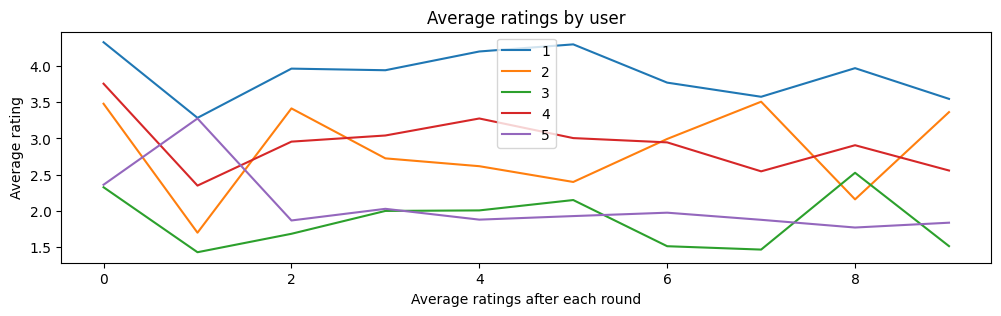

In [117]:
import matplotlib.pyplot as plt

# Plot the average ratings of the users
plt.figure(figsize=(12, 3))
plt.plot(average_ratings_by_user)
plt.xlabel("Average ratings after each round")
plt.ylabel("Average rating")
plt.title("Average ratings by user")
plt.legend(user_ids)
plt.show()

From the results we can see that our method works as intended. For example the user 5 who after the first round had the lowest average rating was after the next movie more satisfied while the user 1 saw a dip in their average satisfaction. This is because the user 1 was ignored in the second round. 

However, what we can also see is that the model in our test scenario cannot make users who dislike alot of movies to like next movies. This is why in our results the users 3 and 5 have generally lower average rating than the others. 

Interesting finding is that the user 1 stays in top of the group even though they are ignored in all of the rounds after the first round. This is because they happen to have similar taste to the other users in the group. This is not a problem but a good demonstration that even though our model ignores the user 1 completely they still feel satisfied of the movie recommendations. 